# 金融风控信用评分卡模型

## 一、数据获取

数据来自Kaggle的[Give Me Some Credit](https://link.jianshu.com?t=https://www.kaggle.com/c/GiveMeSomeCredit/data)，有15万条的样本数据，下图可以看到这份数据的大致情况。
数据属于个人消费类贷款，只考虑信用评分最终实施时能够使用到的数据应从如下一些方面获取数据：
- 基本属性：包括了借款人当时的年龄。
- 偿债能力：包括了借款人的月收入、负债比率。
- 信用往来：两年内35-59天逾期次数、两年内60-89天逾期次数、两年内90天或高于90天逾期的次数。
- 财产状况：包括了开放式信贷和贷款数量、不动产贷款或额度数量。
- 贷款属性：暂无。
- 其他因素：包括了借款人的家属数量（不包括本人在内）。
- 时间窗口：自变量的观察窗口为过去两年，因变量表现窗口为未来两年。

![img](./img/7744536-11bd43ba74266260.png)

## 二、数据预处理

在对数据处理之前，需要对数据的缺失值和异常值情况进行了解。Python内有describe()函数，可以了解数据集的缺失值、均值和中位数等。



In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #导入图像库
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
from scipy import stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor

#载入数据
data = pd.read_csv('cs-training.csv')
#数据集确实和分布情况
# data.describe().to_csv('DataDescribe.csv')
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


可知，变量MonthlyIncome和NumberOfDependents存在缺失，变量MonthlyIncome共有缺失值29731个，NumberOfDependents有3924个缺失值。

### 2.1 缺失值处理

这种情况在现实问题中非常普遍，这会导致一些不能处理缺失值的分析方法无法应用，因此，在信用风险评级模型开发的第一步我们就要进行缺失值处理。缺失值处理的方法，包括如下几种。
- （1） 直接删除含有缺失值的样本。
- （2） 根据样本之间的相似性填补缺失值。
- （3） 根据变量之间的相关关系填补缺失值。
变量MonthlyIncome缺失率比较大，所以我们根据变量之间的相关关系填补缺失值，我们采用随机森林法：

NumberOfDependents变量缺失值比较少，直接删除，对总体模型不会造成太大影响。对缺失值处理完之后，删除重复项。



In [ ]:
# 用随机森林对缺失值预测填充函数
def set_missing(df):
    # 把已有的数值型特征取出来
    process_df = df.iloc[:,[5,0,1,2,3,4,6,7,8,9]]
    # 分成已知该特征和未知该特征两部分
    known = process_df[process_df.MonthlyIncome.notnull()].values  
    unknown = process_df[process_df.MonthlyIncome.isnull()].values
    # X为特征属性值
    X = known[:, 1:]
    # y为结果标签值
    y = known[:, 0]
    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, n_estimators=200,max_depth=3,n_jobs=-1)
    rfr.fit(X,y)

    # 用得到的模型进行未知特征值预测
    predicted = rfr.predict(unknown[:, 1:]).round(0)
    print(predicted)
    # 用得到的预测结果填补原缺失数据
    df.loc[(df.MonthlyIncome.isnull()), 'MonthlyIncome'] = predicted
    return df

data=set_missing(data)#用随机森林填补比较多的缺失值
data= data.dropna()#删除比较少的缺失值
data = data.drop_duplicates()#删除重复项
data.to_csv('MissingData.csv',index=False)
data.describe()

[8311. 1159. 8311. ... 1159. 2554. 2554.]


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,145563.000000,145563.000000,145563.000000,145563.000000,145563.000000,1.455630e+05,145563.000000,145563.000000,145563.000000,145563.000000,145563.000000
mean,0.067538,5.941378,52.110701,0.389185,334.548251,6.116310e+03,8.553788,0.231309,1.033346,0.205622,0.759863
std,0.250952,250.510835,14.567652,3.756944,1947.228209,1.318221e+04,5.141132,3.728803,1.133115,3.712455,1.116141
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.031218,41.000000,0.000000,0.173934,2.554000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.158817,52.000000,0.000000,0.359090,5.000000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.561085,62.000000,0.000000,0.770641,8.166000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,107.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


### 2.2 异常值处理

缺失值处理完毕后，我们还需要进行异常值处理。异常值是指明显偏离大多数抽样数据的数值，比如个人客户的年龄为0时，通常认为该值为异常值。找出样本总体中的异常值，通常采用离群值检测的方法。
首先，我们发现变量age中存在0，显然是异常值，直接剔除：



对于变量NumberOfTime30-59DaysPastDueNotWorse、NumberOfTimes90DaysLate、NumberOfTime60-89DaysPastDueNotWorse这三个变量，由下面的箱线图图3-2可以看出，均存在异常值，且由unique函数可以得知均存在96、98两个异常值，因此予以剔除。同时会发现剔除其中一个变量的96、98值，其他变量的96、98两个值也会相应被剔除。

剔除变量NumberOfTime30-59DaysPastDueNotWorse、NumberOfTimes90DaysLate、NumberOfTime60-89DaysPastDueNotWorse的异常值。另外，数据集中好客户为0，违约客户为1，考虑到正常的理解，能正常履约并支付利息的客户为1，所以我们将其取反。



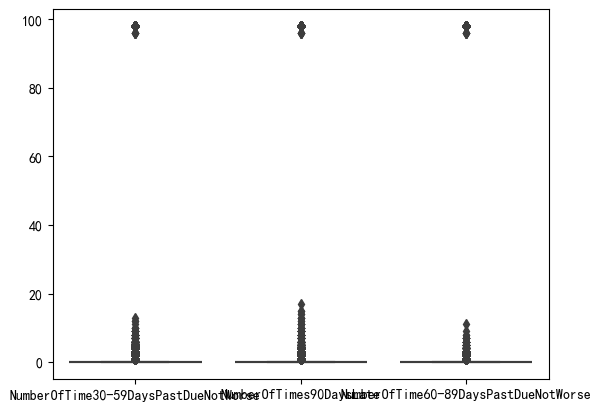

In [ ]:
data = pd.read_csv('MissingData.csv')
# 箱形图
data379=data[['NumberOfTime30-59DaysPastDueNotWorse','NumberOfTimes90DaysLate','NumberOfTime60-89DaysPastDueNotWorse']]
sns.boxplot(data=data379)
plt.show()

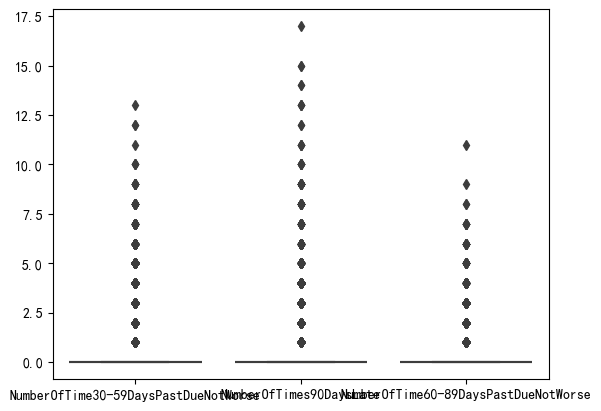

In [57]:
data = data[data['NumberOfTime30-59DaysPastDueNotWorse'] < 90]
data379 = data[['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse']]
sns.boxplot(data=data379)
plt.show()
# 年龄等于0的异常值进行剔除
data = data[data['age'] > 0]
#变量SeriousDlqin2yrs取反
data['SeriousDlqin2yrs']=1-data['SeriousDlqin2yrs']

In [58]:
### 对数据集进行切分，分成训练集和测试集。
from sklearn.model_selection import train_test_split 

Y = data['SeriousDlqin2yrs']
X = data.iloc[:, 1:]

# 查看数据基本情况
print(f"特征变量形状: {X.shape}")
print(f"目标变量分布:\n{Y.value_counts(normalize=True).round(4) * 100}%")

#测试集占比30%
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

# 创建训练集和测试集
train = pd.concat([Y_train, X_train], axis=1)
test = pd.concat([Y_test, X_test], axis=1)

# 检查训练集和测试集中的目标变量分布
print("\n训练集中的目标变量分布:")
print(train.groupby('SeriousDlqin2yrs')['SeriousDlqin2yrs'].count())
print(f"训练集中的未违约率: {train['SeriousDlqin2yrs'].mean() * 100:.2f}%")

print("\n测试集中的目标变量分布:")
print(test.groupby('SeriousDlqin2yrs')['SeriousDlqin2yrs'].count())
print(f"测试集中的未违约率: {test['SeriousDlqin2yrs'].mean() * 100:.2f}%")

# 保存训练集和测试集
train.to_csv('TrainData.csv', index=False)
test.to_csv('TestData.csv', index=False)
print("\n数据已保存为 TrainData.csv 和 TestData.csv")

特征变量形状: (145354, 10)
目标变量分布:
SeriousDlqin2yrs
1    93.32
0     6.68
Name: proportion, dtype: float64%

训练集中的目标变量分布:
SeriousDlqin2yrs
0     6813
1    94934
Name: SeriousDlqin2yrs, dtype: int64
训练集中的未违约率: 93.30%

测试集中的目标变量分布:
SeriousDlqin2yrs
0     2893
1    40714
Name: SeriousDlqin2yrs, dtype: int64
测试集中的未违约率: 93.37%

数据已保存为 TrainData.csv 和 TestData.csv


## 三、探索性分析
在建立模型之前，我们一般会对现有的数据进行 探索性数据分析（Exploratory Data Analysis）。 EDA是指对已有的数据(特别是调查或观察得来的原始数据)在尽量少的先验假定下进行探索。常用的探索性数据分析方法有：直方图、散点图和箱线图等。

客户年龄分布如图所示，可以看到年龄变量大致呈正态分布，符合统计分析的假设。


训练数据维度: (101747, 11)


d:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1000x600 with 0 Axes>

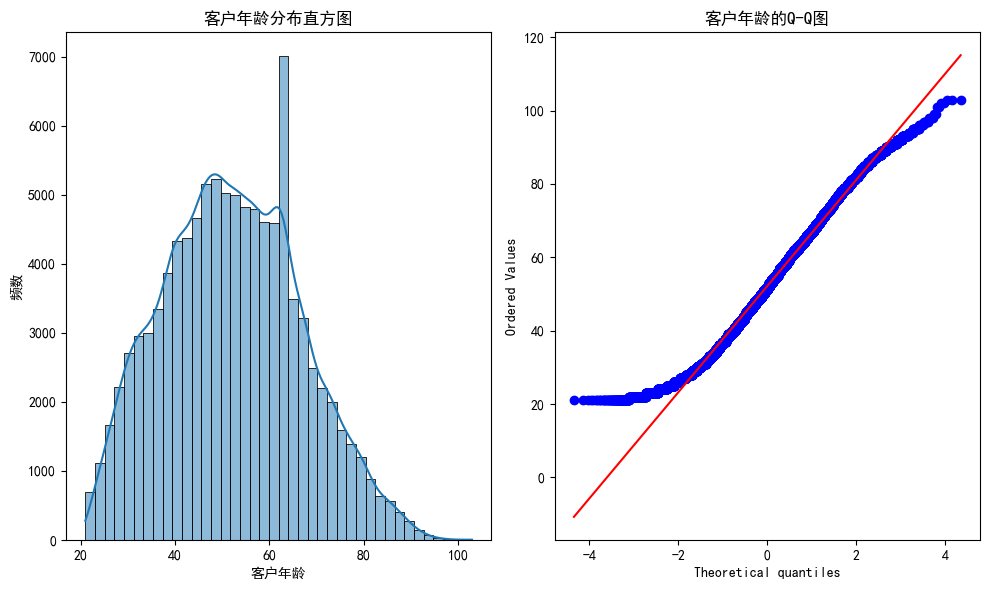


客户年龄的描述性统计:
count    101747.000000
mean         52.157666
std          14.529511
min          21.000000
25%          41.000000
50%          52.000000
75%          62.000000
max         103.000000
Name: age, dtype: float64


In [ ]:
# 加载已保存的训练数据
train = pd.read_csv('TrainData.csv')
print(f"训练数据维度: {train.shape}")

#探索性数据分析
def plot_distribution(data, column, title, bins=30, figsize=(10, 6)):
    """绘制变量分布图"""
    plt.figure(figsize=figsize)
    
    # 创建两个子图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # 直方图和核密度估计图
    sns.histplot(data[column].dropna(), kde=True, bins=bins, ax=ax1)
    ax1.set_title(f'{title}分布直方图')
    ax1.set_xlabel(title)
    ax1.set_ylabel('频数')
    
    # 正态Q-Q图
    stats.probplot(data[column].dropna(), plot=ax2)
    ax2.set_title(f'{title}的Q-Q图')
    
    plt.tight_layout()
    plt.show()
    
    # 打印描述性统计
    desc = data[column].describe()
    print(f"\n{title}的描述性统计:")
    print(desc)
    # # 检查是否有异常值
    # Q1 = desc['25%']
    # Q3 = desc['75%']
    # IQR = Q3 - Q1
    # lower_bound = Q1 - 1.5 * IQR
    # upper_bound = Q3 + 1.5 * IQR
    # outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)][column]
    # print(f"\n{title}的异常值数量: {len(outliers)}, 占比: {len(outliers)/len(data)*100:.2f}%")

# 分析客户年龄分布
plot_distribution(train, 'age', '客户年龄',bins=40)


## 四、变量选择

特征变量选择(排序)对于数据分析、机器学习从业者来说非常重要。好的特征选择能够提升模型的性能，更能帮助我们理解数据的特点、底层结构，这对进一步改善模型、算法都有着重要作用。至于Python的变量选择代码实现可以参考[结合Scikit-learn介绍几种常用的特征选择方法](https://www.cnblogs.com/hhh5460/p/5186226.html)。
在本文中，我们采用信用评分模型的变量选择方法，通过WOE分析方法，即是通过比较指标分箱和对应分箱的违约概率来确定指标是否符合经济意义。首先我们对变量进行离散化（分箱）处理。

<Figure size 1000x600 with 0 Axes>

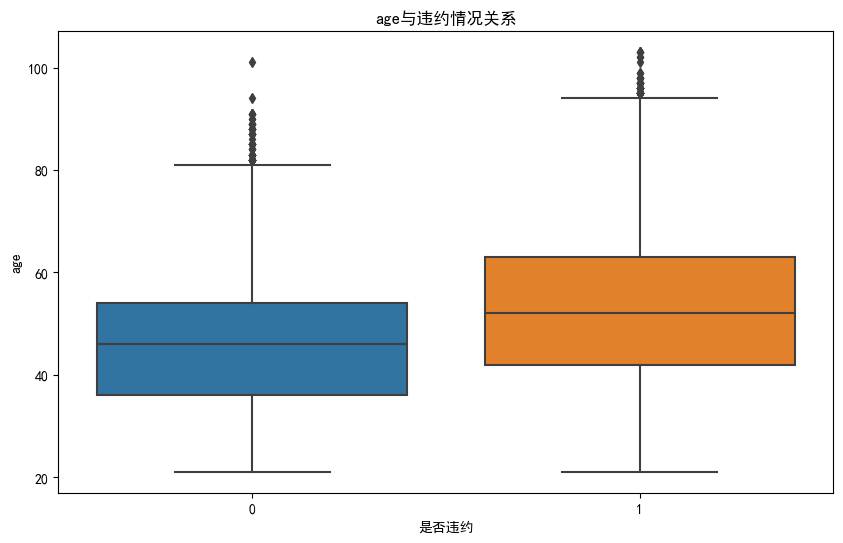


age在违约/非违约客户间的t检验结果:
t统计量: 40.8371
p值: 0.0000
统计显著性: 显著


<Figure size 1000x600 with 0 Axes>

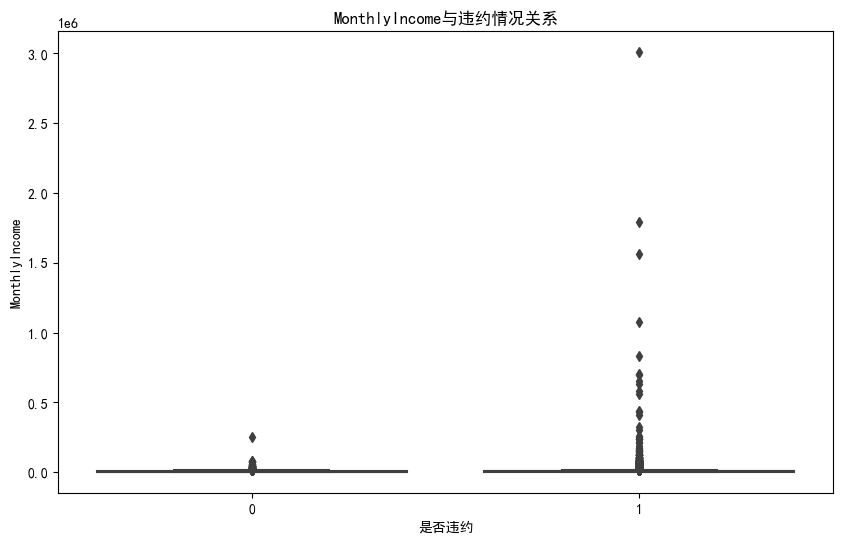


MonthlyIncome在违约/非违约客户间的t检验结果:
t统计量: 10.7730
p值: 0.0000
统计显著性: 显著


<Figure size 1000x600 with 0 Axes>

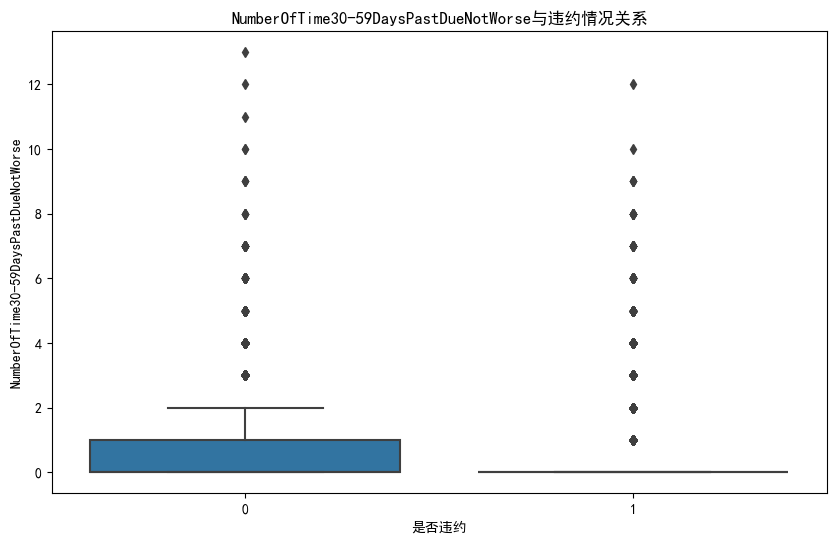


NumberOfTime30-59DaysPastDueNotWorse在违约/非违约客户间的t检验结果:
t统计量: -46.1597
p值: 0.0000
统计显著性: 显著


<Figure size 1000x600 with 0 Axes>

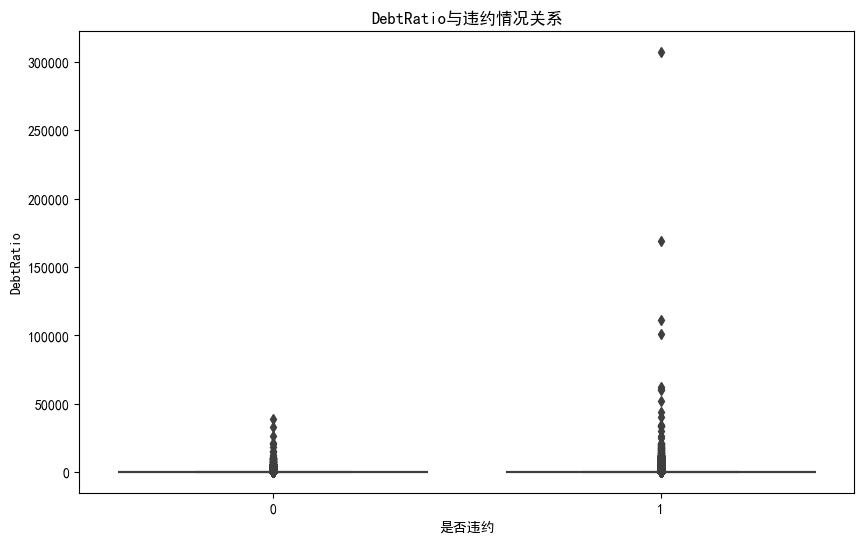


DebtRatio在违约/非违约客户间的t检验结果:
t统计量: 2.9661
p值: 0.0030
统计显著性: 显著


<Figure size 1000x600 with 0 Axes>

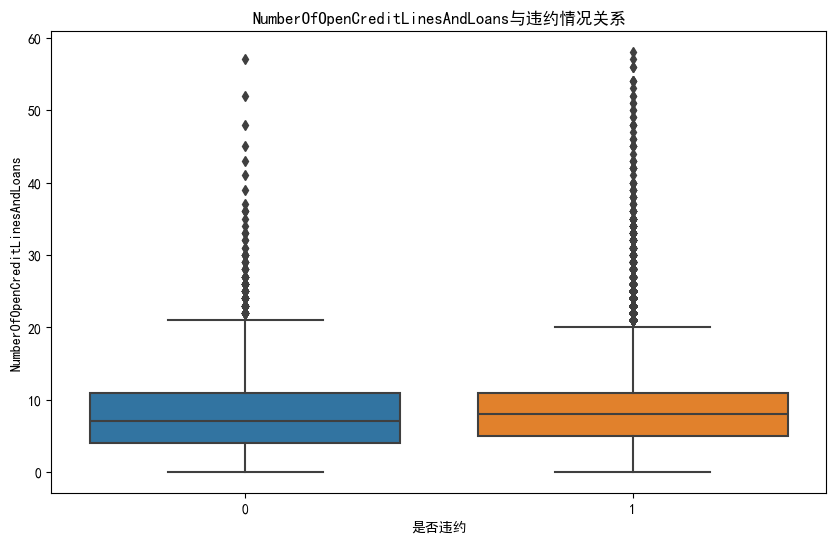


NumberOfOpenCreditLinesAndLoans在违约/非违约客户间的t检验结果:
t统计量: 6.9149
p值: 0.0000
统计显著性: 显著


In [ ]:
# 各变量与目标变量的关系分析
def plot_feature_target_relation(data, feature, target='SeriousDlqin2yrs', figsize=(10, 6)):
    """分析特征与目标变量的关系"""
    plt.figure(figsize=figsize)
    
    # 对于数值型变量，使用箱线图
    if data[feature].dtype in ['int64', 'float64'] and data[feature].nunique() > 10:
        plt.figure(figsize=figsize)
        sns.boxplot(x=target, y=feature, data=data)
        plt.title(f'{feature}与违约情况关系')
        plt.xlabel('是否违约')
        plt.ylabel(feature)
        plt.show()
        
        # 计算两组统计差异
        default = data[data[target] == 1][feature]
        non_default = data[data[target] == 0][feature]
        t_stat, p_value = stats.ttest_ind(default.dropna(), non_default.dropna(), equal_var=False)
        print(f"\n{feature}在违约/非违约客户间的t检验结果:")
        print(f"t统计量: {t_stat:.4f}")
        print(f"p值: {p_value:.4f}")
        print(f"统计显著性: {'显著' if p_value < 0.05 else '不显著'}")
    
    # 对于分类变量或离散数值变量，使用条形图
    else:
        # 计算每个类别的违约率
        grouped = data.groupby(feature)[target].mean().reset_index()
        grouped = grouped.sort_values(target, ascending=False)
        
        plt.figure(figsize=figsize)
        sns.barplot(x=feature, y=target, data=grouped, palette='viridis')
        plt.title(f'不同{feature}的违约率')
        plt.xlabel(feature)
        plt.ylabel('违约率')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # 计算卡方检验
        contingency = pd.crosstab(data[feature], data[target])
        chi2, p, _, _ = stats.chi2_contingency(contingency)
        print(f"\n{feature}与违约情况的卡方检验结果:")
        print(f"卡方值: {chi2:.4f}")
        print(f"p值: {p:.4f}")
        print(f"统计显著性: {'显著' if p < 0.05 else '不显著'}")

# 分析关键特征与违约关系
important_features = ['age', 'MonthlyIncome', 'NumberOfTime30-59DaysPastDueNotWorse', 
                      'DebtRatio', 'NumberOfOpenCreditLinesAndLoans']

for feature in important_features:
    plot_feature_target_relation(train, feature)


### 4.1 分箱处理

变量分箱（binning）是对连续变量离散化（discretization）的一种称呼。信用评分卡开发中一般有常用的等距分段、等深分段、最优分段。其中等距分段（Equval length intervals）是指分段的区间是一致的，比如年龄以十年作为一个分段；等深分段（Equal frequency intervals）是先确定分段数量，然后令每个分段中数据数量大致相等；最优分段（Optimal Binning）又叫监督离散化（supervised discretizaion），使用递归划分（Recursive Partitioning）将连续变量分为分段，背后是一种基于条件推断查找较佳分组的算法。
我们首先选择对连续变量进行最优分段，在连续变量的分布不满足最优分段的要求时，再考虑对连续变量进行等距分段。最优分箱的代码如下：

In [41]:
def mono_bin(Y, X, n=20):
    """
    基于单调性的自动分箱函数 
    参数:
    Y: Series, 目标变量 (0/1)
    X: Series, 特征变量
    n: int, 初始分箱数量
    
    返回:
    bins_df: DataFrame, 分箱统计结果
    iv: float, Information Value
    cut_points: list, 实际使用的分割点
    woe_values: list, 各分箱的WOE值
    """
    # 计算好坏样本总数
    good = Y.sum()
    bad = Y.count() - good
    
    # 初始化相关系数和实际分箱结果
    r = 0
    final_buckets = None
    
    # 寻找满足单调性要求的分箱数
    while np.abs(r) < 0.5 and n > 2:
        try:
            # 等频分箱，保存分箱对象以获取实际分割点
            buckets = pd.qcut(X, n, duplicates='drop', retbins=True)
            actual_bins = buckets[1]  # 获取实际分割点
            
            # 创建包含分箱结果的DataFrame
            d1 = pd.DataFrame({"X": X, "Y": Y, "Bucket": buckets[0]})
            
            # 按分箱分组计算统计量
            d2 = d1.groupby('Bucket', as_index=True, observed=True)
            
            # 计算分箱均值与目标变量的相关性
            x_mean = d2.mean()['X']
            y_mean = d2.mean()['Y']
            r, p = stats.spearmanr(x_mean, y_mean)
            
            # 如果满足单调性要求，保存分箱结果
            if np.abs(r) >= 0.5:
                final_buckets = buckets
                break
                
        except Exception as e:
            print(f"分箱数 {n} 出错: {str(e)}")
        
        # 减少分箱数量并继续尝试
        n = n - 1
    
    if n <= 2:
        print("警告: 达到最小分箱数(2)，单调性可能不足")
    
    if final_buckets is None:
        # 即使不满足单调性，也使用最后一次尝试的分箱结果
        buckets = pd.qcut(X, n, duplicates='drop', retbins=True)
        actual_bins = buckets[1]
        d1 = pd.DataFrame({"X": X, "Y": Y, "Bucket": buckets[0]})
        d2 = d1.groupby('Bucket', as_index=True, observed=True)
    else:
        actual_bins = final_buckets[1]
    
    # 创建分箱统计信息DataFrame
    d3 = pd.DataFrame({
        'min': d2.min()['X'],
        'max': d2.max()['X'],
        'sum': d2.sum()['Y'],
        'total': d2.count()['Y'],
        'rate': d2.mean()['Y']
    })
    
    # 计算WOE和IV
    epsilon = 1e-10
    d3['woe'] = np.log(
        (d3['rate'] + epsilon) / (1 - d3['rate'] + epsilon) / 
        ((good + epsilon) / (bad + epsilon))
    )
    d3['goodattribute'] = d3['sum'] / good
    d3['badattribute'] = (d3['total'] - d3['sum']) / bad
    
    # 计算IV
    iv = ((d3['goodattribute'] - d3['badattribute']) * d3['woe']).sum()
    
    # 按最小值排序
    d4 = d3.sort_values(by='min')
    
    # 打印分箱结果
    print("=" * 60)
    print(f"分箱数: {n}, 相关系数: {r:.4f}")
    print(d4)
    print(f"IV值: {iv:.4f}")
    
    # 使用实际的分箱边界，确保一致性
    cut = [float('-inf')] + list(actual_bins[1:]) + [float('inf')]
    
    # 生成WOE值列表，确保与分箱顺序一致
    woe = list(d4['woe'].round(3))
    
    return d4, iv, cut, woe


def self_bin(Y, X, cat):
    """
    自定义分箱函数，根据给定的分割点进行分箱
    
    参数:
    Y: Series, 目标变量 (0/1)
    X: Series, 特征变量
    cat: list, 分箱的分割点列表
    
    返回:
    bins_df: DataFrame, 分箱统计结果
    iv: float, Information Value
    woe_values: list, 各分箱的WOE值
    """
    # 计算好坏样本总数
    good = Y.sum()
    bad = Y.count() - good
    
    # 数据预处理
    X_copy = X.copy()
    try:
        # 使用自定义分割点创建分箱
        d1 = pd.DataFrame({'X': X_copy, 'Y': Y, 'Bucket': pd.cut(X_copy, cat)})
                
        # 按分箱分组，明确设置observed参数以避免警告
        d2 = d1.groupby('Bucket', as_index=True, observed=True)
        
        # 创建分箱统计DataFrame
        d3 = pd.DataFrame({
            'min': d2['X'].min(),
            'max': d2['X'].max(),
            'sum': d2['Y'].sum(),      # 好样本数
            'total': d2['Y'].count(),  # 总样本数
            'rate': d2['Y'].mean()     # 好样本率
        })
        
        # 添加防止除零和对数错误的小值
        epsilon = 1e-10
        
        # 计算WOE和IV
        d3['woe'] = np.log(
            (d3['rate'] + epsilon) / (1 - d3['rate'] + epsilon) / 
            ((good + epsilon) / (bad + epsilon))
        )
        
        # 处理无穷大的WOE值
        d3.loc[np.isinf(d3['woe']), 'woe'] = 0
        
        # 计算每个分箱对IV的贡献
        d3['goodattribute'] = d3['sum'] / good
        d3['badattribute'] = (d3['total'] - d3['sum']) / bad
        d3['iv_component'] = (d3['goodattribute'] - d3['badattribute']) * d3['woe']
        
        # 计算总IV
        iv = d3['iv_component'].sum()
        
        # 按最小值排序
        d4 = d3.sort_values(by='min')
        
        # 添加违约率和样本占比
        d4['bad_rate'] = 1 - d4['rate']
        d4['percent'] = d4['total'] / d4['total'].sum() * 100
        
        # 打印分箱结果
        print("=" * 60)
        print("分箱统计结果:")
        print(d4[['min', 'max', 'total', 'sum', 'rate', 'woe', 'iv_component']])
        print(f"总IV值: {iv:.4f}")
        
        # 提取分箱的WOE值列表
        woe_values = list(d4['woe'].round(3))
        
        return d4, iv, woe_values
        
    except Exception as e:
        print(f"分箱过程中出错: {str(e)}")
        raise

### 4.2 WOE分析

WoE分析， 是对指标分箱、计算各个档位的WoE值并观察WoE值随指标变化的趋势。其中WoE的数学定义是:
woe=ln(goodattribute/badattribute)
在进行分析时，我们需要对各指标从小到大排列，并计算出相应分档的WoE值。其中正向指标越大，WoE值越小；反向指标越大，WoE值越大。正向指标的WoE值负斜率越大，反向指标的正斜率越大，则说明指标区分能力好。WoE值趋近于直线，则意味指标判断能力较弱。若正向指标和WoE正相关趋势、反向指标同WoE出现负相关趋势，则说明此指标不符合经济意义，则应当予以去除。
woe函数实现在上一节的mono_bin()函数里面已经包含，这里不再重复。

分箱数: 10, 相关系数: -0.8788
                        min           max    sum  total      rate       woe  \
Bucket                                                                        
(-0.001, 0.00345]  0.000000      0.003452   9907  10175  0.973661  0.975661   
(0.00345, 0.0202]  0.003453      0.020188  10030  10175  0.985749  1.602253   
(0.0202, 0.0451]   0.020189      0.045067  10017  10174  0.984569  1.521444   
(0.0451, 0.0858]   0.045070      0.085777   9974  10175  0.980246  1.270083   
(0.0858, 0.158]    0.085781      0.157927   9908  10175  0.973759  0.979500   
(0.158, 0.275]     0.157928      0.275369   9827  10174  0.965893  0.709215   
(0.275, 0.447]     0.275402      0.446807   9631  10175  0.946536  0.239444   
(0.447, 0.695]     0.446818      0.694665   9271  10174  0.911244 -0.305425   
(0.695, 0.972]     0.694684      0.972249   8552  10175  0.840491 -0.972460   
(0.972, 50708.0]   0.972280  50708.000000   7817  10175  0.768256 -1.435862   

                   goodattri

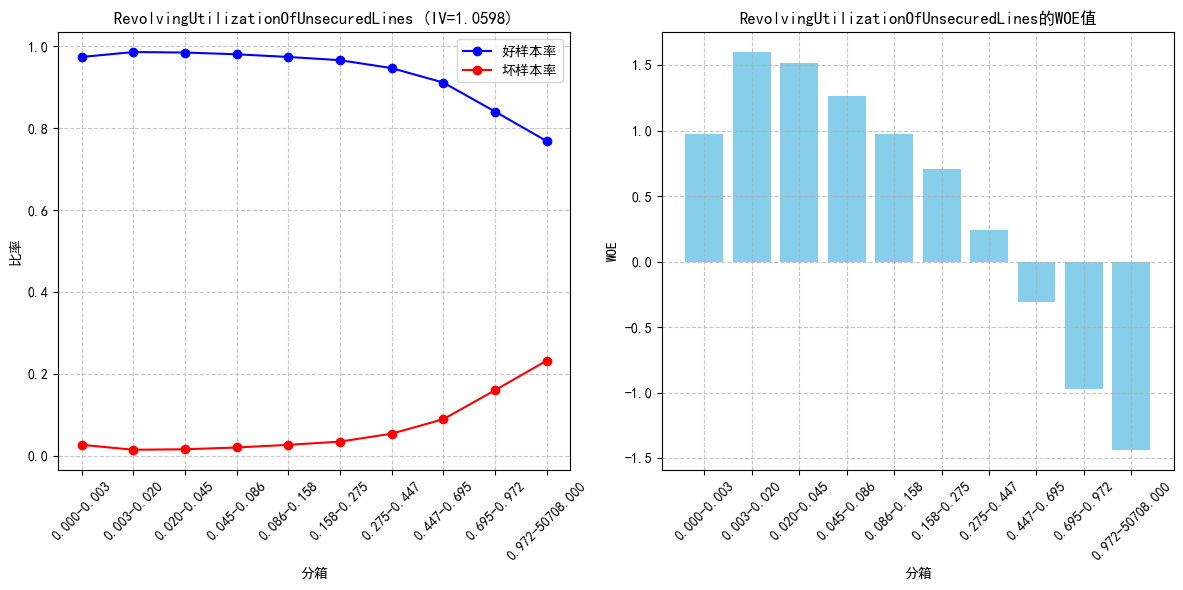


分箱点: [-inf, 0.0034524906000000005, 0.0201884364, 0.04506940420000001, 0.08577852820000001, 0.157926836, 0.2753889682000002, 0.44680881879999995, 0.6946803846, 0.9722614986000002, 50708.0, inf]
WOE值: [0.976, 1.602, 1.521, 1.27, 0.979, 0.709, 0.239, -0.305, -0.972, -1.436]


In [42]:
data = pd.read_csv('TrainData.csv')
dfx1, ivx1, cutx1, woex1=mono_bin(data.SeriousDlqin2yrs,data.RevolvingUtilizationOfUnsecuredLines,n=10)

# 可视化分箱结果
plt.figure(figsize=(12, 6))

# 绘制好坏样本率
plt.subplot(1, 2, 1)
plt.plot(range(len(dfx1)), dfx1['rate'], 'o-', color='blue', label='好样本率')
plt.plot(range(len(dfx1)), 1 - dfx1['rate'], 'o-', color='red', label='坏样本率')
plt.title(f'RevolvingUtilizationOfUnsecuredLines (IV={ivx1:.4f})')
plt.xlabel('分箱')
plt.xticks(range(len(dfx1)), [f"{row['min']:.3f}-{row['max']:.3f}" for _, row in dfx1.iterrows()], rotation=45)
plt.ylabel('比率')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# 绘制WOE值
plt.subplot(1, 2, 2)
plt.bar(range(len(dfx1)), dfx1['woe'], color='skyblue')
plt.title('RevolvingUtilizationOfUnsecuredLines的WOE值')
plt.xlabel('分箱')
plt.xticks(range(len(dfx1)), [f"{row['min']:.3f}-{row['max']:.3f}" for _, row in dfx1.iterrows()], rotation=45)
plt.ylabel('WOE')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 打印有用的信息
print(f"\n分箱点: {cutx1}")
print(f"WOE值: {woex1}")
    

In [43]:
dfx2, ivx2, cutx2, woex2=mono_bin(data.SeriousDlqin2yrs, data.age, n=10)
dfx4, ivx4, cutx4, woex4 =mono_bin(data.SeriousDlqin2yrs, data.DebtRatio, n=20)
dfx5, ivx5, cutx5, woex5 =mono_bin(data.SeriousDlqin2yrs, data.MonthlyIncome, n=10)

分箱数: 10, 相关系数: 1.0000
                min  max    sum  total      rate       woe  goodattribute  \
Bucket                                                                      
(20.999, 33.0]   21   33  10081  11342  0.888820 -0.555602       0.106190   
(33.0, 39.0]     34   39   9217  10208  0.902919 -0.404259       0.097089   
(39.0, 44.0]     40   44  10018  10973  0.912968 -0.283922       0.105526   
(44.0, 48.0]     45   48   9282  10106  0.918464 -0.212688       0.097773   
(48.0, 52.0]     49   52   9435  10206  0.924456 -0.129856       0.099385   
(52.0, 56.0]     53   56   9126   9775  0.933606  0.009101       0.096130   
(56.0, 60.0]     57   60   8668   9128  0.949606  0.301818       0.091306   
(60.0, 65.0]     61   65  10752  11205  0.959572  0.532606       0.113258   
(65.0, 72.0]     66   72   9355   9604  0.974073  0.991864       0.098542   
(72.0, 103.0]    73  103   9000   9200  0.978261  1.172313       0.094803   

                badattribute  
Bucket                

针对我们将使用最优分段对于数据集中的RevolvingUtilizationOfUnsecuredLines、age、DebtRatio和MonthlyIncome进行分类。
针对不能最优分箱的变量，分箱如下：

In [44]:
# 连续变量离散化
pinf = float('inf')#正无穷大
ninf = float('-inf')#负无穷大
cutx3 = [ninf, 0, 1, 3, 5, pinf]
cutx6 = [ninf, 1, 2, 3, 5, pinf]
cutx7 = [ninf, 0, 1, 3, 5, pinf]
cutx8 = [ninf, 0,1,2, 3, pinf]
cutx9 = [ninf, 0, 1, 3, pinf]
cutx10 = [ninf, 0, 1, 2, 3, 5, pinf]

dfx3, ivx3, woex3 = self_bin(data.SeriousDlqin2yrs, data['NumberOfTime30-59DaysPastDueNotWorse'], cutx3)
dfx6, ivx6 ,woex6= self_bin(data.SeriousDlqin2yrs, data['NumberOfOpenCreditLinesAndLoans'], cutx6)
dfx7, ivx7,woex7 = self_bin(data.SeriousDlqin2yrs, data['NumberOfTimes90DaysLate'], cutx7)
dfx8, ivx8,woex8 = self_bin(data.SeriousDlqin2yrs, data['NumberRealEstateLoansOrLines'], cutx8)
dfx9, ivx9,woex9 = self_bin(data.SeriousDlqin2yrs, data['NumberOfTime60-89DaysPastDueNotWorse'], cutx9)
dfx10, ivx10,woex10 = self_bin(data.SeriousDlqin2yrs, data['NumberOfDependents'], cutx10)

分箱统计结果:
             min  max  total    sum      rate       woe  iv_component
Bucket                                                               
(-inf, 0.0]    0    0  85334  81862  0.959313  0.525955      0.185499
(0.0, 1.0]     1    1  11139   9467  0.849897 -0.900558      0.131203
(1.0, 3.0]     2    3   4363   3102  0.710979 -1.734207      0.264314
(3.0, 5.0]     4    5    733    416  0.567531 -2.362566      0.099574
(5.0, inf]     6   13    178     87  0.488764 -2.679301      0.033332
总IV值: 0.7139
分箱统计结果:
             min  max  total    sum      rate       woe  iv_component
Bucket                                                               
(-inf, 1.0]    0    1   3661   3048  0.832559 -1.030473      0.059632
(1.0, 2.0]     2    2   4306   3895  0.904552 -0.385494      0.007439
(2.0, 3.0]     3    3   6020   5565  0.924419 -0.130395      0.001065
(3.0, 5.0]     4    5  16437  15387  0.936120  0.050383      0.000401
(5.0, inf]     6   58  71323  67039  0.939935  0.116038      

### 4.3 IV筛选

由上图可以看出，各变量之间的相关性是非常小的。NumberOfOpenCreditLinesAndLoans和NumberRealEstateLoansOrLines的相关性系数为0.43。
接下来，我进一步计算每个变量的Infomation Value（IV）。IV指标是一般用来确定自变量的预测能力。 其公式为：
IV=sum((goodattribute-badattribute)\*ln(goodattribute/badattribute))
通过IV值判断变量预测能力的标准是：
```
< 0.02: unpredictive
0.02 to 0.1: weak
0.1 to 0.3: medium
0.3 to 0.5: strong
> 0.5: suspicious
```
IV的实现放在mono_bin()函数和自定义分箱函数里面。


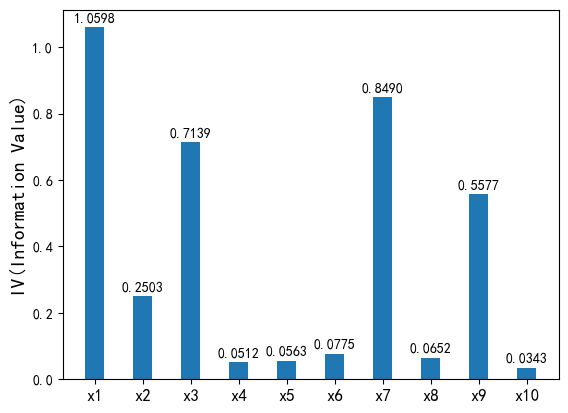

In [45]:
ivlist=[ivx1,ivx2,ivx3,ivx4,ivx5,ivx6,ivx7,ivx8,ivx9,ivx10]
index=['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10']
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(1, 1, 1)
x = np.arange(len(index))+1
ax1.bar(x, ivlist, width=0.4)
ax1.set_xticks(x)
ax1.set_xticklabels(index, rotation=0, fontsize=12)
ax1.set_ylabel('IV(Information Value)', fontsize=14)
for a, b in zip(x, ivlist):
    plt.text(a, b + 0.01, '%.4f' % b, ha='center', va='bottom', fontsize=10)
plt.show()

从输出的各变量IV图可以看出，DebtRatio、MonthlyIncome、NumberOfOpenCreditLinesAndLoans、NumberRealEstateLoansOrLines和NumberOfDependents变量的IV值明显较低，所以予以删除。

### 4.4 小结
以上介绍了信用评分模型开发过程中的数据预处理、探索性分析和变量选择。数据预处理主要针对缺失值用随机森林法和直接剔除法进行处理，对于异常值主要根据实际情况和箱形图的数据分布，对异常值进行剔除；探索性分析主要对各变量的分布情况进行初始的探究；变量选择主要考虑了变量的分箱方法，根据分箱结果计算WOE值，然后检查变量之间的相关性，根据各变量的IV值来选择对数据处理有好效果的变量。
接下来会介绍信用评分模型的模型开发、模型评估和信用评分等。

## 五、模型分析

证据权重（Weight of Evidence,WOE）转换可以将Logistic回归模型转变为标准评分卡格式。引入WOE转换的目的并不是为了提高模型质量，只是一些变量不应该被纳入模型，这或者是因为它们不能增加模型值，或者是因为与其模型相关系数有关的误差较大，其实建立标准信用评分卡也可以不采用WOE转换。这种情况下，Logistic回归模型需要处理更大数量的自变量。尽管这样会增加建模程序的复杂性，但最终得到的评分卡都是一样的。
在建立模型之前，我们需要将筛选后的变量转换为WoE值，便于信用评分。

### 5.1 WOE转换

我们已经能获取了每个变量的分箱数据和woe数据，只需要根据各变量数据进行替换，实现代码如下：

In [24]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import scipy.stats.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math

def replace_woe(series, cut, woe):
    """
    将原始特征值转换为WOE值 
    
    参数:
    series: Series, 原始特征值
    cut: list, 分箱的分割点
    woe: list, 每个分箱对应的WOE值
    
    返回:
    Series: 转换后的WOE值序列
    """
    # 创建一个与输入相同长度的结果Series
    result = pd.Series(index=series.index, dtype='float64')
    
    # 使用向量化操作代替循环
    for i in range(len(woe)):
        # 确定当前箱的上下边界
        lower_bound = cut[i]
        upper_bound = cut[i+1]
        
        # 找到所有落在这个区间内的值
        if i == 0:  # 第一个箱，包含下边界
            mask = (series >= lower_bound) & (series < upper_bound)
        elif i == len(woe) - 1:  # 最后一个箱，包含上边界
            mask = (series >= lower_bound) & (series <= upper_bound)
        else:  # 中间的箱，只包含下边界
            mask = (series >= lower_bound) & (series < upper_bound)
        
        # 给相应位置赋值
        result[mask] = woe[i]
    
    # 检查是否有值未被分配WOE值（超出范围或缺失值）
    missing_mask = result.isna()
    if missing_mask.any():
        # 输出警告
        missing_count = missing_mask.sum()
        print(f"警告: 变量有 {missing_count} 个值不在任何分箱范围内，将使用中位数WOE值代替")
        
        # 使用中位数WOE填充（可以根据需要调整为其他策略）
        result[missing_mask] = np.median(woe)
    
    return result
    
# 训练数据集替换成woe 
data['RevolvingUtilizationOfUnsecuredLines'] = replace_woe(data['RevolvingUtilizationOfUnsecuredLines'], cutx1, woex1)
data['age'] = replace_woe(data['age'], cutx2, woex2)
data['NumberOfTime30-59DaysPastDueNotWorse'] = replace_woe(data['NumberOfTime30-59DaysPastDueNotWorse'], cutx3, woex3)
data['DebtRatio'] = replace_woe(data['DebtRatio'], cutx4, woex4)
data['MonthlyIncome'] = replace_woe(data['MonthlyIncome'], cutx5, woex5)
data['NumberOfOpenCreditLinesAndLoans'] = replace_woe(data['NumberOfOpenCreditLinesAndLoans'], cutx6, woex6)
data['NumberOfTimes90DaysLate'] = replace_woe(data['NumberOfTimes90DaysLate'], cutx7, woex7)
data['NumberRealEstateLoansOrLines'] = replace_woe(data['NumberRealEstateLoansOrLines'], cutx8, woex8)
data['NumberOfTime60-89DaysPastDueNotWorse'] = replace_woe(data['NumberOfTime60-89DaysPastDueNotWorse'], cutx9, woex9)
data['NumberOfDependents'] = replace_woe(data['NumberOfDependents'], cutx10, woex10)
data.to_csv('TrainWoeData.csv', index=False)

# 测试数据集替换成woe 
test = pd.read_csv('TestData.csv')
test['RevolvingUtilizationOfUnsecuredLines'] = replace_woe(test['RevolvingUtilizationOfUnsecuredLines'], cutx1, woex1)
test['age'] = replace_woe(test['age'], cutx2, woex2)
test['NumberOfTime30-59DaysPastDueNotWorse'] = replace_woe(test['NumberOfTime30-59DaysPastDueNotWorse'], cutx3, woex3)
test['DebtRatio'] = replace_woe(test['DebtRatio'], cutx4, woex4)
test['MonthlyIncome'] = replace_woe(test['MonthlyIncome'], cutx5, woex5)
test['NumberOfOpenCreditLinesAndLoans'] = replace_woe(test['NumberOfOpenCreditLinesAndLoans'], cutx6, woex6)
test['NumberOfTimes90DaysLate'] = replace_woe(test['NumberOfTimes90DaysLate'], cutx7, woex7)
test['NumberRealEstateLoansOrLines'] = replace_woe(test['NumberRealEstateLoansOrLines'], cutx8, woex8)
test['NumberOfTime60-89DaysPastDueNotWorse'] = replace_woe(test['NumberOfTime60-89DaysPastDueNotWorse'], cutx9, woex9)
test['NumberOfDependents'] = replace_woe(test['NumberOfDependents'], cutx10, woex10)
test.to_csv('TestWoeData.csv', index=False)

警告: 变量有 1 个值不在任何分箱范围内，将使用中位数WOE值代替
警告: 变量有 2 个值不在任何分箱范围内，将使用中位数WOE值代替


### 5.2 Logisic Regression模型建立

我们直接调用statsmodels包来实现逻辑回归：

In [29]:
import statsmodels.api as sm

data = pd.read_csv('TrainWoeData.csv')
Y = data['SeriousDlqin2yrs']
X = data.drop(['SeriousDlqin2yrs','DebtRatio','MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
               'NumberRealEstateLoansOrLines','NumberOfDependents'],axis=1)
X = sm.add_constant(X)
logit=sm.Logit(Y,X)

result=logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.185995
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:       SeriousDlqin2yrs   No. Observations:               101747
Model:                          Logit   Df Residuals:                   101741
Method:                           MLE   Df Model:                            5
Date:                  周日, 16 3月 2025   Pseudo R-squ.:                  0.2430
Time:                        23:36:26   Log-Likelihood:                -18924.
converged:                       True   LL-Null:                       -25000.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    9.4968      0.1

通过上述可知，逻辑回归各变量都已通过显著性检验，满足要求。

### 5.3 模型检验

到这里，我们的建模部分基本结束了。我们需要验证一下模型的预测能力如何。我们使用在建模开始阶段预留的test数据进行检验。通过ROC曲线和AUC来评估模型的拟合能力。
在Python中，可以利用sklearn.metrics，它能方便比较两个分类器，自动计算ROC和AUC。
实现代码：

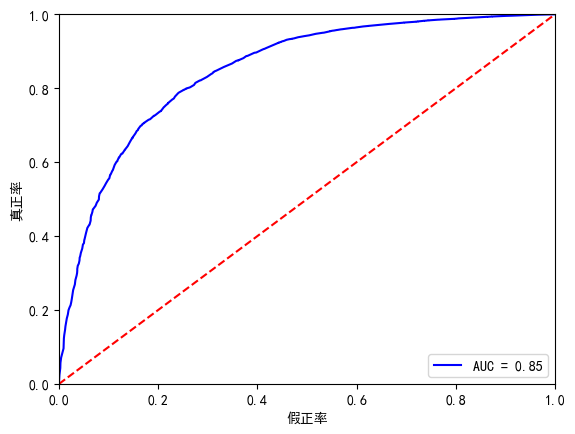

In [30]:
from sklearn.metrics import roc_curve, auc

test = pd.read_csv('TestWoeData.csv')
Y_test = test['SeriousDlqin2yrs']
X_test = test.drop(['SeriousDlqin2yrs', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines', 'NumberOfDependents'], axis=1)
X = sm.add_constant(X_test)
resu = result.predict(X)
fpr, tpr, threshold = roc_curve(Y_test, resu)
rocauc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % rocauc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('真正率')
plt.xlabel('假正率')
plt.show()

ROC曲线

从上图可知，AUC值为0.85，说明该模型的预测效果还是不错的，正确率较高。


## 六、信用评分

我们已经基本完成了建模相关的工作，并用ROC曲线验证了模型的预测能力。接下来的步骤，就是将Logistic模型转换为标准评分卡的形式。

### 6.1 评分标准

![img](./img/7744536-cb7b3ab9620ddfe3.jpg)

![img](./img/7744536-d966b6dadbffd4c1.jpg)

a=log（p_good/P_bad）

Score = offset + factor \* log(odds)

**个人总评分=基础分+各部分得分**

In [ ]:
#计算分数
coe = result.params #coe为逻辑回归模型的系数
# 我们取600分为基础分值，PDO为20（每高20分好坏比翻一倍），好坏比取20。
p = 20 / math.log(2)
q = 600 - 20 * math.log(20) / math.log(2)
baseScore = round(q + p * coe[0], 0)

In [51]:
# 计算分数函数
def get_score(coe, woe, factor):
    """
    根据系数和WOE计算分数
    
    参数:
    coe: float, 特征系数
    woe: list, WOE值列表
    factor: float, 分数缩放因子
    
    返回:
    list: 各分箱对应的分数
    """
    return [round(coe * w * factor, 0) for w in woe]

# 各项部分分数
x1 = get_score(coe[1], woex1, p)
x2 = get_score(coe[2], woex2, p)
x3 = get_score(coe[3], woex3, p)
x7 = get_score(coe[4], woex7, p)
x9 = get_score(coe[5], woex9, p)

print("分数:")
print(f"基础分: {baseScore}")
# 展示分箱区间woex1及对应分数
print("分箱区间及对应分数:")
print(f"RevolvingUtilizationOfUnsecuredLines: {cutx1}")
print(f"分数: {x1}")
print("=" * 60) 
# 展示分箱区间woex2及对应分数
print("分箱区间及对应分数:")        
print(f"age: {cutx2}")
print(f"分数: {x2}")
print("=" * 60)
# 展示分箱区间woex3及对应分数
print("分箱区间及对应分数:")
print(f"NumberOfTime30-59DaysPastDueNotWorse: {cutx3}")
print(f"分数: {x3}")
print("=" * 60)
# 展示分箱区间woex7及对应分数
print("分箱区间及对应分数:")
print(f"NumberOfTimes90DaysLate: {cutx7}")
print(f"分数: {x7}")
print("=" * 60)
# 展示分箱区间woex9及对应分数
print("分箱区间及对应分数:")
print(f"NumberOfTime60-89DaysPastDueNotWorse: {cutx9}")
print(f"分数: {x9}")
print("=" * 60)


分数:
基础分: 788.0
分箱区间及对应分数:
RevolvingUtilizationOfUnsecuredLines: [-inf, 0.0034524906000000005, 0.0201884364, 0.04506940420000001, 0.08577852820000001, 0.157926836, 0.2753889682000002, 0.44680881879999995, 0.6946803846, 0.9722614986000002, 50708.0, inf]
分数: [18.0, 30.0, 28.0, 23.0, 18.0, 13.0, 4.0, -6.0, -18.0, -27.0]
分箱区间及对应分数:
age: [-inf, 33.0, 39.0, 44.0, 48.0, 52.0, 56.0, 60.0, 65.0, 72.0, 103.0, inf]
分数: [-8.0, -5.0, -4.0, -3.0, -2.0, 0.0, 4.0, 7.0, 13.0, 16.0]
分箱区间及对应分数:
NumberOfTime30-59DaysPastDueNotWorse: [-inf, 0, 1, 3, 5, inf]
分数: [16.0, -27.0, -52.0, -71.0, -80.0]
分箱区间及对应分数:
NumberOfTimes90DaysLate: [-inf, 0, 1, 3, 5, inf]
分数: [19.0, -96.0, -134.0, -157.0, -152.0]
分箱区间及对应分数:
NumberOfTime60-89DaysPastDueNotWorse: [-inf, 0, 1, 3, inf]
分数: [9.0, -59.0, -86.0, -93.0]


In [59]:
# 根据变量计算分数
def compute_score(series, cut, score):
    """
    计算每个原始特征值对应的分数
    
    参数:
    series: Series, 原始特征值
    cut: list, 分箱的分割点
    score: list, 每个分箱对应的分数
    
    返回:
    Series: 转换后的分数序列
    """
    # 创建一个与输入相同长度的结果Series
    result = pd.Series(index=series.index, dtype='float64')
    
    # 使用向量化操作代替循环
    for i in range(len(score)):
        # 确定当前箱的上下边界
        lower_bound = cut[i]
        upper_bound = cut[i+1]
        
        # 找到所有落在这个区间内的值
        if i == 0:  # 第一个箱，包含下边界
            mask = (series >= lower_bound) & (series < upper_bound)
        elif i == len(score) - 1:  # 最后一个箱，包含上边界
            mask = (series >= lower_bound) & (series <= upper_bound)
        else:  # 中间的箱，只包含下边界
            mask = (series >= lower_bound) & (series < upper_bound)
        
        # 给相应位置赋值
        result[mask] = score[i]
    
    # 检查是否有值未被分配分数（超出范围或缺失值）
    missing_mask = result.isna()
    if missing_mask.any():
        # 输出警告
        missing_count = missing_mask.sum()
        print(f"警告: 变量有 {missing_count} 个值不在任何分箱范围内，将使用中位数分数代替")
        
        # 使用中位数分数填充（可以根据需要调整为其他策略）
        result[missing_mask] = np.median(score)
    
    return result

test1 = pd.read_csv('TestData.csv')
test1['BaseScore'] = baseScore  # 不需要创建零序列然后加基础分，直接赋值更高效

# 计算各项得分
test1['x1'] = compute_score(test1['RevolvingUtilizationOfUnsecuredLines'], cutx1, x1)
test1['x2'] = compute_score(test1['age'], cutx2, x2)
test1['x3'] = compute_score(test1['NumberOfTime30-59DaysPastDueNotWorse'], cutx3, x3)
test1['x7'] = compute_score(test1['NumberOfTimes90DaysLate'], cutx7, x7)
test1['x9'] = compute_score(test1['NumberOfTime60-89DaysPastDueNotWorse'], cutx9, x9)
test1['Score'] = test1['x1'] + test1['x2'] + test1['x3'] + test1['x7'] + test1['x9'] + baseScore
test1.to_csv('ScoreData.csv', index=False)

#展示test1数据集
test1[['SeriousDlqin2yrs','x1','x2','x3','x7','x9','Score']].head(20)


警告: 变量有 1 个值不在任何分箱范围内，将使用中位数分数代替


,SeriousDlqin2yrs,x1,x2,x3,x7,x9,Score
0,1,-6.0,-4.0,-71.0,-134.0,-59.0,514.0
1,1,23.0,4.0,-27.0,-96.0,-59.0,633.0
2,1,4.0,-3.0,-27.0,-96.0,-59.0,607.0
3,1,18.0,13.0,-27.0,-96.0,-59.0,637.0
4,1,30.0,-5.0,-27.0,-96.0,-59.0,631.0
5,1,28.0,16.0,-27.0,-96.0,-59.0,650.0
6,1,-27.0,-2.0,-27.0,-96.0,-59.0,577.0
7,1,13.0,13.0,-27.0,-96.0,-59.0,632.0
8,1,28.0,-2.0,-27.0,-96.0,-59.0,632.0
9,1,13.0,-5.0,-27.0,-96.0,-59.0,614.0


## 七、总结以及展望

这里通过对kaggle上的[Give Me Some Credit](https://link.jianshu.com?t=https://www.kaggle.com/c/GiveMeSomeCredit/data)数据的挖掘分析，结合信用评分卡的建立原理，从数据的预处理、变量选择、建模分析到创建信用评分，创建了一个简单的信用评分系统。
基于AI 的机器学习评分卡系统可通过把旧数据（某个时间点后，例如2年）剔除掉后再进行自动建模、模型评估、并不断优化特征变量，使得系统更加强大。